In [13]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import json
import pickle as pkl
from shapely.geometry import Polygon, Point
import numpy as np

# Load the zipcode data set

In [14]:
# Load the geojson of the zipcodes

with open('./data/external/seattle-zipcodes.geojson') as f:
    zipcodes = json.load(f)

In [15]:
# Extract the zipcode centroids for clustering
zipcode_centroids = {}

for zipcode in zipcodes['features']:
    zipcode_id = zipcode['properties']['ZCTA5CE10']
    poly = Polygon([tuple(corr) for corr in zipcode['geometry']['coordinates'][0]])
    centroid = poly.centroid
    
    zipcode_centroids[zipcode_id] = {'latitude': centroid.y, 'longitude': centroid.x}
    
zipcode_centroids = pd.DataFrame.from_dict(zipcode_centroids, orient='index')
zipcode_centroids.head()

,latitude,longitude
98136,47.536759,-122.389865
98144,47.585815,-122.292670
98109,47.631592,-122.344166
98195,47.649253,-122.309195
98199,47.651392,-122.402693


In [16]:
def zipcode_cluster():
    # Find the optimal number of clusters to use
    K_clusters = range(2,15)
    lat_long = zipcode_centroids.iloc[:,0:2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    sse =[]

    for k in K_clusters:
        kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
        kmeans.fit(lat_long)
        sse.append(kmeans.inertia_)


    plt.plot(K_clusters, sse)
    plt.xlabel('Number of Clusters')
    plt.ylabel('SSE')
    plt.title(f'Elbow Curve')
    plt.show()

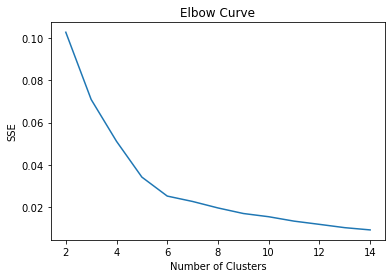

In [17]:
zipcode_cluster()

In [18]:
def get_cluster_id():
    pd.options.mode.chained_assignment = None
    # Find the optimal number of clusters to use
    lat_long = zipcode_centroids.iloc[:,0:2]

    # Set the parameters for KMeans
    kmeans_kwargs = {"init": "random",
                    "n_init": 10,
                    "max_iter": 1000,
                    "random_state": 42}

    
    kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
    kmeans.fit(lat_long)

    zipcode_centroids.loc[:,'cluster_id'] = kmeans.predict(lat_long)
    pd.options.mode.chained_assignment = 'warn'
    return zipcode_centroids['cluster_id'].to_dict()

In [19]:
# Map the clusters to the complete dataset
clusters = get_cluster_id()
zipcode_centroids['cluster_id']= zipcode_centroids.index.map(clusters)
zipcode_centroids.reset_index(inplace=True)
zipcode_centroids.rename(columns={'index':'zipcode'}, inplace=True)
zipcode_centroids.head()

,zipcode,latitude,longitude,cluster_id
0,98136,47.536759,-122.389865,2
1,98144,47.585815,-122.292670,5
2,98109,47.631592,-122.344166,5
3,98195,47.649253,-122.309195,3
4,98199,47.651392,-122.402693,0


# Visualize the clusters

In [20]:
fig = px.choropleth_mapbox(zipcode_centroids,
                        geojson=zipcodes, 
                        locations='zipcode', 
                        featureidkey="properties.ZCTA5CE10", 
                        color='cluster_id',
                        color_continuous_scale="viridis",
                        mapbox_style="carto-positron",
                        zoom=10.5, center={"lat": 47.609, "lon": -122.334},
                        opacity=0.7
)
fig.update_layout(height=1000, width=1000, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


In [21]:
# adjust zipcode 98112 to cluster 5 (yellow)
zipcode_centroids.cluster_id = np.where(zipcode_centroids.zipcode == 98112, 5, zipcode_centroids.cluster_id)

In [22]:
zipcode_centroids.zipcode = zipcode_centroids.zipcode.astype(str)
zipcode_centroids.set_index('zipcode', inplace=True)

In [23]:
# Save the zipcode cluster ID's 
# zipcode_centroids.set_index('ZIPCODE', inplace=True)
cluster_id = zipcode_centroids.cluster_id.to_dict()

with open('./data/seattle_zipcode_clusters.pickle', 'wb') as handle:
    pkl.dump(cluster_id, handle)